In [ ]:
# Import libaraies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/zihanyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zihanyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Preprocess Data

### 1.1 Drop unrelated columns and NA/None values

In [3]:
def clean_data(folder='data',files = ['Automotive_5.json','CDs_and_Vinyl_5.json','Cell_Phones_and_Accessories_5.json','Grocery_and_Gourmet_Food_5.json','Toys_and_Games_5.json']):
    
    review_files = {}
    
    for file_name in files:
        name = file_name.split('_')[0]
        row  = pd.read_json(folder+'/'+file_name,lines=True)
        # Delete all columns except 'Ooverall', 'reviewText', 'summary'
        row = row.drop(columns=['verified','reviewTime','reviewerID','asin','reviewerName','unixReviewTime','vote','image','style'])
        print(f"For category {name}")
        print(row.isnull().sum())
        print(f"Dataset before dropping: {len(row)}")
        # Delet all null rows
        row = row.dropna()
        print(f"Dataset after dropping: {len(row)}")
        row['reviewText'] = row['reviewText']
        review_files[name] = row
    
    return review_files

In [4]:
df_collect = clean_data()

For category Automotive
overall         0
reviewText    866
summary       342
dtype: int64
Dataset before dropping: 1711519
Dataset after dropping: 1710350
For category CDs
reviewText    280
overall         0
summary       227
dtype: int64
Dataset before dropping: 1443755
Dataset after dropping: 1443288
For category Cell
overall         0
reviewText    765
summary       517
dtype: int64
Dataset before dropping: 1128437
Dataset after dropping: 1127206
For category Grocery
overall         0
reviewText    390
summary       219
dtype: int64
Dataset before dropping: 1143860
Dataset after dropping: 1143292
For category Toys
overall          0
reviewText    1175
summary        372
dtype: int64
Dataset before dropping: 1828971
Dataset after dropping: 1827456


In [ ]:
""""
def read_file(filepath):
    seg_docs = {}
    
    with open(filepath, 'r') as file:
        file_dict = json.load(file)
    
    seg_docs = {}
    
    for key, text in file_dict.items():
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = word_tokenize(text)
        words_list = []
        for word in words:
            if word not in stop_words:
                words_list.append(word)
        
        seg_docs[key] = words_list
    
    return seg_docs
    """

In [ ]:
"""
def strip_clean(reviews_dict):
    
    def process_entry(sentence):
        sentence = sentence.lower()
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        words_list = []
        for word in sentence:
            if word not in stop_words():
                words_list.append(word)
        return words_list
    
    stripped_dict = {}
    
    for key,df in reviews_dict.items():
        df['reviewText'] = df['reviewText'].apply(process_entry)
        df['summary'] = df['summary'].apply(process_entry)
        stripped_dict[key] = df
    
    return stripped_dict
    """

In [ ]:
# df_reduced_list = strip_clean(df_collect)

In [ ]:
df_reduced_list['Automotive']

In [5]:
print(df_collect.keys())

dict_keys(['Automotive', 'CDs', 'Cell', 'Grocery', 'Toys'])


### 1.2 Drop duplicates

In [6]:
def drop_duplicate(tables):
    # Initialize a dictionary to store data
    clean_tables = {}
    for name, table in tables.items():
        print(f"For category {name}")
        
        # Convert the table into dataframe
        df = pd.DataFrame(table)
        duplicates = df.duplicated()
        print(f"Number of duplicate: {duplicates.sum()}")

        print(f"Before dropping: {len(df)}")
        df_drop_dup = df.drop_duplicates()
        print(f"After dropping: {len(df_drop_dup)}")

        # Store the cleaned data into dictionary
        clean_tables[name] = df_drop_dup
    return clean_tables

In [7]:
# Drop duplicates
df_drop_dup = drop_duplicate(df_collect)

For category Automotive
Number of duplicate: 322354
Before dropping: 1710350
After dropping: 1387996
For category CDs
Number of duplicate: 191204
Before dropping: 1443288
After dropping: 1252084
For category Cell
Number of duplicate: 171530
Before dropping: 1127206
After dropping: 955676
For category Grocery
Number of duplicate: 230906
Before dropping: 1143292
After dropping: 912386
For category Toys
Number of duplicate: 326697
Before dropping: 1827456
After dropping: 1500759


In [8]:
def pie_chart_statistic(tables):
    for name, table in tables.items():
        # Convert to series and count the 'overall ratings'
        counts = pd.Series(table['overall']).value_counts()
        print(f"Number of ratings of {name}: {counts}")

        # Define the parameters of the pie charts
        plt.figure(figsize = (6,6))
        plt.pie(
            counts,
            labels = counts.index,
            autopct = '%1.1f%%',
            startangle = 90,
            wedgeprops = {'edgecolor': 'black'}
        )

        plt.title(f"Distribution of Overall Ratings in {name}")
        plt.show()

Number of ratings of Automotive: overall
5    971580
4    202218
3     91867
1     74017
2     48314
Name: count, dtype: int64


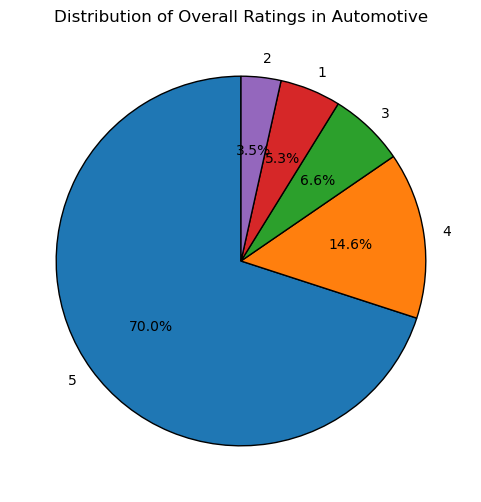

Number of ratings of CDs: overall
5    813811
4    250756
3    102760
2     43769
1     40988
Name: count, dtype: int64


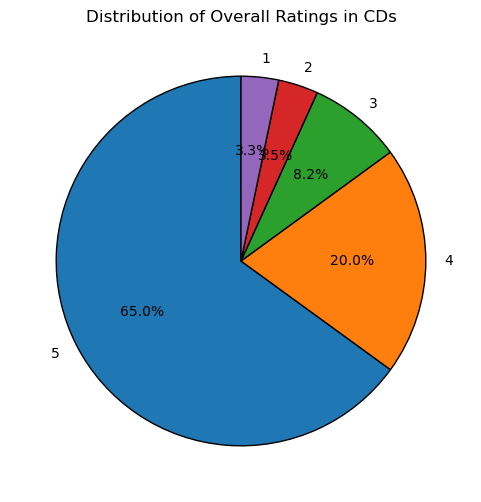

Number of ratings of Cell: overall
5    569477
4    163280
3     90656
1     77448
2     54815
Name: count, dtype: int64


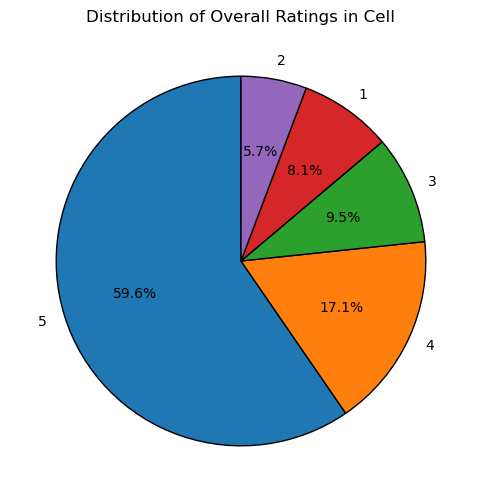

Number of ratings of Grocery: overall
5    637248
4    124386
3     69986
1     43417
2     37349
Name: count, dtype: int64


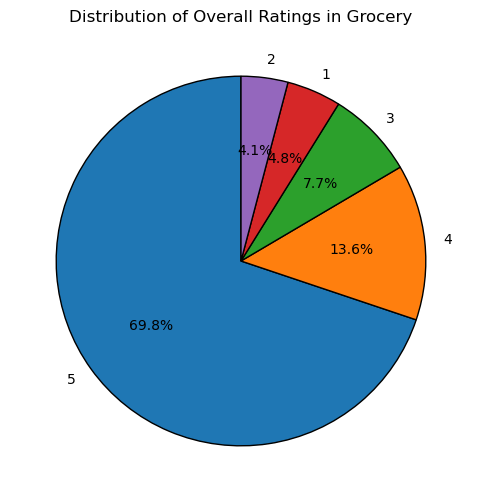

Number of ratings of Toys: overall
5    1025714
4     241122
3     120025
1      59163
2      54735
Name: count, dtype: int64


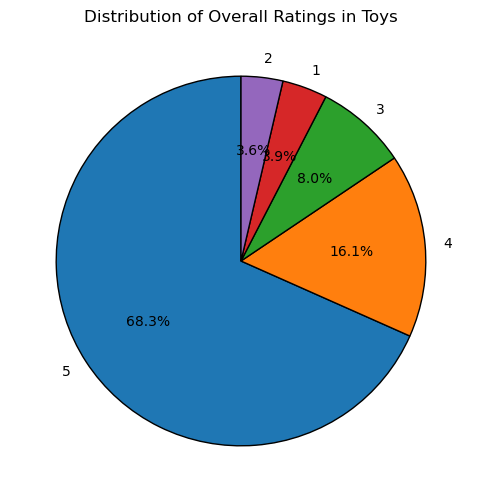

In [9]:
# Draw the pie charts
pie_chart_statistic(df_drop_dup)

The dataset is highly inbalanced.

### 1.3 Tokenization

In [10]:
def create_category_dataframes(tables):
    for category, data in tables.items():
       globals()[f"df_{category}"] = pd.DataFrame(data)

# Seperate each category to a table
create_category_dataframes(df_drop_dup)

In [11]:
# Concat the 5 tables to a large dataframe
dataframes = [df_Automotive, df_CDs, df_Cell, df_Grocery, df_Toys]
df_drop_dup1 = pd.concat(dataframes, axis = 0)

df_drop_dup1 = df_drop_dup1.reset_index(drop=True)
df_drop_dup1.head()

,overall,reviewText,summary
0,4,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...
1,1,It sucks barely picks up anything definitely n...,sucks
2,1,"Well to write a short one, it blew 2 fuses of ...",Defective
3,3,I have absolutely no memory of buying this but...,Looks cool! Probably works
4,5,it ok it does it job,Five Stars


In [12]:
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def tokenize_text(text):
    # Lowercase 
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Filter out stopwords and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

In [ ]:
# Copy a new data frame to store the tokenized data
df_token = df_drop_dup1.copy()
# Tokenize 'reviewText' and 'summary'
df_token['reviewText'] = df_token['reviewText'].apply(tokenize_text)
df_token['summary'] = df_token['summary'].apply(tokenize_text)
df_token.head()

,overall,reviewText,summary
0,4,"[wrote, review, manufactur, contact, explain, ...","[work, well, place, phone, horizont, landscap,..."
1,1,"[suck, bare, pick, anyth, definit, car, pretti...",[suck]
2,1,"[well, write, short, one, blew, 2, fuse, car, ...",[defect]
3,3,"[absolut, memori, buy, go, review, goe, away, ...","[look, cool, probabl, work]"
4,5,"[ok, job]","[five, star]"


In [13]:
def tokenization_statistics(column,column_name):
     # Vocabulary size
     vocabulary = set(token for tokens in column for token in tokens)
     vocabulary_size = len(vocabulary)

     print(f"Statistics of '{column_name}':")
     print(f"Vocabulary size: {vocabulary_size}")

In [25]:
# Do some statistics
print(f"Number of total reviews: {len(df_token)}")
# The vocabulary size of 'reviewText' and 'summary'
tokenization_statistics(df_token['reviewText'], 'reviewText')
tokenization_statistics(df_token['summary'], 'summary')

Number of total reviews: 6008901
Statistics of 'reviewText':
Vocabulary size: 598826
Statistics of 'summary':
Vocabulary size: 134096


## Step 2: Vectorization

To avoid information leakage, here the data is splitted before vectorization

### 2.1 Split training and test set

In [14]:
# Split the train and test size
def split_train_test(df, target_column, test_size = 0.2, random_state = 42):
    y = df[target_column]
    X = df.drop(columns = [target_column])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, 
                                                        random_state= random_state, stratify=y)

    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = split_train_test(df_drop_dup1, 'overall', test_size=0.2, random_state=42)

Use a smaller dataset to test the code

In [ ]:
X_train_auto, X_test_auto, y_train_auto, y_test_auto = split_train_test(df_Automotive, 'overall', test_size= 0.2, random_state= 42)

,reviewText,summary
302818,This part only working for two weeks .dont was...,dont waste your
1461571,Quiet but they don't stop as fast i would get ...,Three Stars
172124,"Perfect fit, easy install, great ride.","Perfect fit, easy install, great ride."
685210,Purchased these to replace some of the clips o...,The clips work just fine with one little issue...
1133075,I had to order the XXL because my thighs are X...,The belt is way too large but the length and f...


### 2.1 Vectorization with tfidf

In [22]:
def encode_tfidf_vectors(train, test, summary = False, max_features = 10000):
    X_train = None
    X_test = None
    vectorizer1 = None
    # Select the column for vectorization
    text_column = 'summary' if summary else 'reviewText'
     # Avoid in-place modification by creating copies
    train_copy = train.copy()
    test_copy = test.copy()
    # Convert tokenized lists into string format
    #train_copy[text_column]=train[text_column].apply(lambda x: ''.join(x))
    #test_copy[text_column]=test[text_column].apply(lambda x: ''.join(x))
    
    # Set parameter for vectorizer
    vectorizer1 = TfidfVectorizer(max_features=max_features, ngram_range=(1, 3), stop_words = 'english')
    # Fit the vectorizer on the training data
    X_train = vectorizer1.fit_transform(train_copy[text_column])
    # Transform the test data using the same vectorizer
    X_test = vectorizer1.transform(test_copy[text_column])
    return X_train, X_test, vectorizer1

In [23]:
# Vectorize the training set
X_train_tfidf, X_test_tfidf, vectorizer = encode_tfidf_vectors(X_train, X_test, summary = True, max_features= 10000)
print(f"Matrix Shape: {X_train_tfidf.shape}") 
print(f"Matrix shape: {X_test_tfidf.shape}")

Matrix Shape: (4807120, 10000)
Matrix shape: (1201781, 10000)


### 2.2 Vectorization with Bag of Word

In [ ]:
def compute_incident_matrix(train, test, summary = False, max_features = 10000):
    X_train = None
    X_test = None
    vectorizer2 = None
    # Select the column for vectorization
    text_column = 'summary' if summary else 'reviewText'
    # Ensure text data is properly joined and avoid in-place modification
    train_copy= train.copy()
    test_copy = test.copy()
    # Convert tokenized lists into string format
    train_copy[text_column]=train[text_column].apply(lambda x: ' '.join(x))
    test_copy[text_column]=test[text_column].apply(lambda x: ' '.join(x))
    
    # Set Countvectorizer
    vectorizer2 = CountVectorizer(max_features=max_features, stop_words = 'english')
    X_train = vectorizer2.fit_transform(train[text_column])
    X_test = vectorizer2.transform(test[text_column])
    return X_train, X_test, vectorizer2

In [ ]:
X_train_auto_bow_summary, X_test_auto_bow_summary, vectorizer = compute_incident_matrix(X_train_auto, 
                                                                                         X_test_auto, summary = True, max_features= 10000)
print(f"Matrix Shape: {X_train_auto_bow_summary.shape}") 
print(f"Matrix shape: {X_test_auto_bow_summary.shape}")

### 2.3 Vectorization with 'Method 3'

## Step 3: Models Training

### 3.1 Model selection

According to the pie charts before, the dataset is highly imbalanced. To address this problem Random Forest, XGBoost, and Support Vector Machine (SVM) are applied.

In [18]:
# Define classifer
cf1 = RandomForestClassifier(n_estimators= 500, max_depth= 20, min_samples_split=5, min_samples_leaf= 2,
                                                class_weight= 'balanced', random_state= 42)
cf2 = XGBClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 6, scale_pos_weight = 8, 
                                  subsample = 0.8,random_state = 42)
cf3 = SVC(kernel='rbf', C =1, class_weight= 'balanced')

### 3.2 Train the data with 'textReview'

### 3.3 Train the model with 'summary'

In [25]:
cf1.fit(X_train_tfidf, y_train)
y_pred = cf1.predict(X_test_tfidf)

## Step 4: Evaluation Criteria

In [20]:
def evaluation_criteria(y_true, y_pred, model_trained, X_test):
    print(f"Evaluation of {model_trained}:")
    # Accuracy score
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy score is: {accuracy}")
    
    # Precision, recall and f1-score
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    
    # ROC AUC score
    y_true_bin = label_binarize(y_true, classes= [1, 2, 3, 4, 5])
    roc_auc = roc_auc_score(y_true_bin, model_trained.predict_proba(X_test), average="macro")
    print(f"Macro averaged ROC AUC: {roc_auc}")

    # print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    display_labels = [1, 2, 3, 4, 5]
    disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= display_labels)
    print("Confusion Matrix:")
    disp.plot(cmap="viridis")


Evaluation of RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=42):
Accuracy score is: 0.472372254179422
Classification report:
              precision    recall  f1-score   support

           1       0.40      0.52      0.45     59007
           2       0.07      0.47      0.11     47796
           3       0.35      0.14      0.20     95059
           4       0.28      0.27      0.28    196352
           5       0.81      0.56      0.66    803567

    accuracy                           0.47   1201781
   macro avg       0.38      0.39      0.34   1201781
weighted avg       0.64      0.47      0.53   1201781

Macro averaged ROC AUC: 0.7113168571609221
Confusion Matrix:


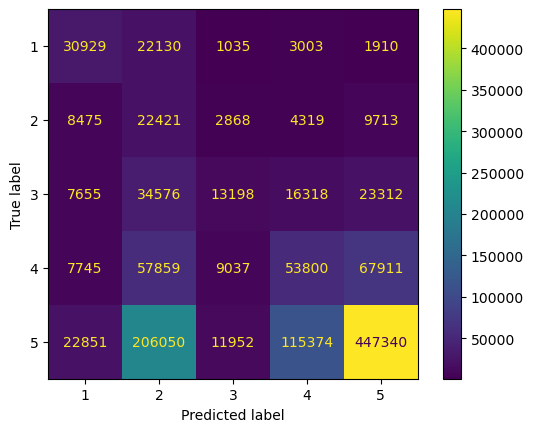

In [26]:
evaluation_criteria(y_test, y_pred, cf1, X_test_tfidf)